# Module AAA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

random.seed(10)

### GDrive setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/Deadline'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/Deadline


In [ ]:
ls

0/    110/  140/  170/  20/   220/  250/  30/  60/  90/
10/   120/  150/  180/  200/  230/  260/  40/  70/  test
100/  130/  160/  190/  210/  240/  270/  50/  80/  test.csv


### Setup

#### Load dataset and remove column features that are not used in module

In [ ]:
deadline_list = [i for i in range(0,271,10)]
df = []

for i in deadline_list:
  temp = pd.read_csv(f'{i}/oulad_AAA_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  df.append(temp)

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
df[0].head()

,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,resource,subpage,url,mean_click
0,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,2,0.0,3.200000,0.0,8.5,0.0,9.900000,1.5,11.000000,0.000000,1.894444
1,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,2,0.0,4.000000,0.0,7.0,0.0,5.000000,1.0,2.600000,1.666667,1.181481
2,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2,0.0,3.625000,1.0,6.0,0.0,7.800000,1.8,3.166667,1.000000,1.355093
3,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,2,0.0,5.384615,2.0,6.5,0.0,6.130435,1.0,1.700000,1.500000,1.345281
4,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,2,0.0,5.629630,0.0,7.2,0.0,4.388889,1.5,2.500000,1.000000,1.234362


#### Plot the correlation matrix with full data

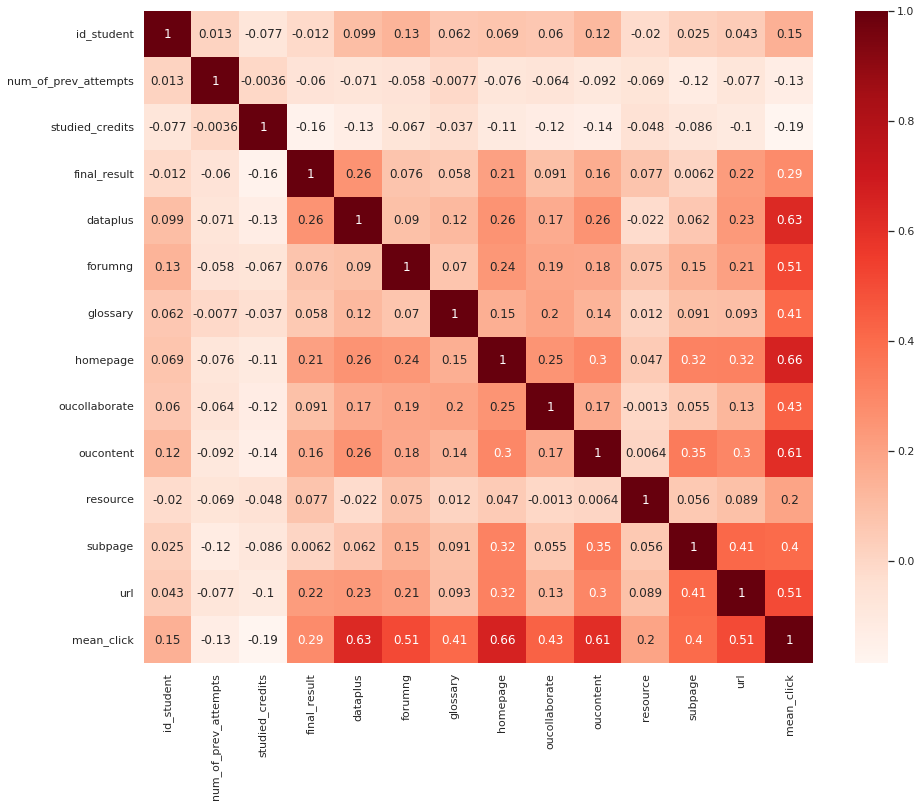

In [ ]:
plt.figure(figsize=(15,12))
cor = df[-1].corr()
# cor = cor.iloc[:,-1].to_numpy().reshape(9,1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# for index, df_day in enumerate(df):
#   df[index] = df_day.drop(['id_student', 'resource', 'studied_credits', 'homepage', 'sharedsubpage', 'num_of_prev_attempts', 'ouelluminate', 'subpage', 'url'], axis=1)
# cor = df[-1].corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

### Make predictions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score

def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [ ]:
from sklearn.pipeline import Pipeline

def encode_df(df):
  # categorise df columns
  df.gender = pd.Categorical(df.gender)
  df.region = pd.Categorical(df.region)
  df.disability = pd.Categorical(df.disability)

  encoding_pipeline = Pipeline([
      ('encoding_label',MultiColumnLabelEncoder(columns=['highest_education','imd_band','age_band'])),
  ])
  df = encoding_pipeline.fit_transform(df)

  # Convert categorical variable into indicator variables. One-hot encoding
  df = pd.get_dummies(df)

  return df

In [ ]:
def split_dataset(df, train_code_presentation, test_code_presentation):   
  test_df = df.loc[df['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation'], axis = 1)

  Y_test = test_df['final_result'].replace({1:0, 2:1, 3:1})
  X_test = test_df.drop('final_result', axis=1)

  train_df = df.loc[df['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation'], axis = 1)

  Y_train = train_df['final_result'].replace({1:0, 2:1, 3:1})
  X_train = train_df.drop('final_result', axis=1)

  
  return encode_df(X_train), encode_df(X_test), Y_train, Y_test


In [ ]:
from sklearn.model_selection import train_test_split

def split_dataset_single_presentation(df, code_presentation):
  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation'], axis = 1)
  
  Y = df_cp['final_result'].replace({1:0, 2:1, 3:1})
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(encode_df(X),Y)


In [ ]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

#### Prepare data for prediction

In [ ]:
from sklearn import preprocessing

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


class MultiColumnOHEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.OneHotEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.OneHotEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

#### 2013J predictions

##### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2013J")

  randomforest = Pipeline([("scaler",StandardScaler()), ("pca",PCA(0.75)), ("nb",RandomForestClassifier())])

  #randomforest = RandomForestClassifier()
  randomforest.fit(X_train, Y_train)
  test_randomforest_predictions = randomforest.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


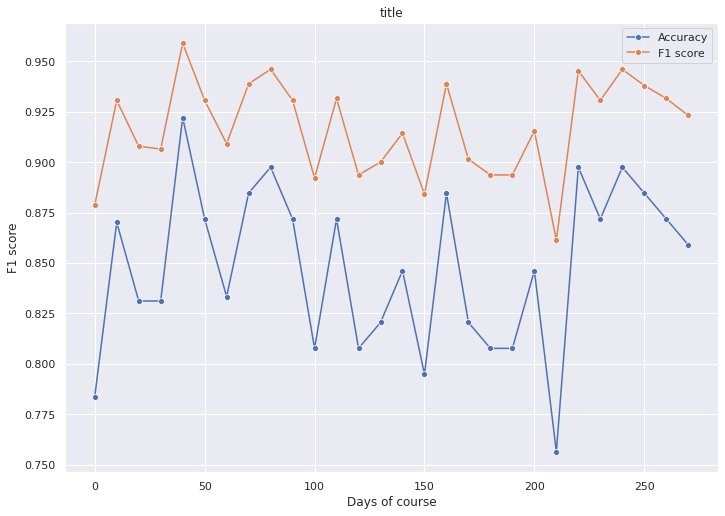

In [ ]:
plot_days(deadline_list,result, "title")

##### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2013J")
  
  nb = GaussianNB()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

In [ ]:
plot_days(deadline_list,result, "title")

##### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2013J")
  
  nb = KNeighborsClassifier()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

In [ ]:
plot_days(deadline_list,result, "title")

#### 2014J Predictions

##### Random Forest Classifier

In [ ]:
result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2014J")
  
  randomforest = RandomForestClassifier()
  randomforest.fit(X_train, Y_train)
  test_randomforest_predictions = randomforest.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

In [ ]:
plot_days(deadline_list,result, "title")

##### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2014J")
  
  nb = GaussianNB()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

In [ ]:
plot_days(deadline_list,result, "title")

##### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2014J")
  
  nb = KNeighborsClassifier()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

In [ ]:
plot_days(deadline_list,result, "title")

#### All course presentations

**Train:** 2013J

**Test:** 2014J

##### Random Forest Classifier

In [ ]:
result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset(df_day, ["2013J"],"2014J")
  
  randomforest = Pipeline([("scaler",StandardScaler()), ("pca",PCA(0.8)), ("nb",RandomForestClassifier())])

  #randomforest = RandomForestClassifier()
  randomforest.fit(X_train, Y_train)
  test_randomforest_predictions = randomforest.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


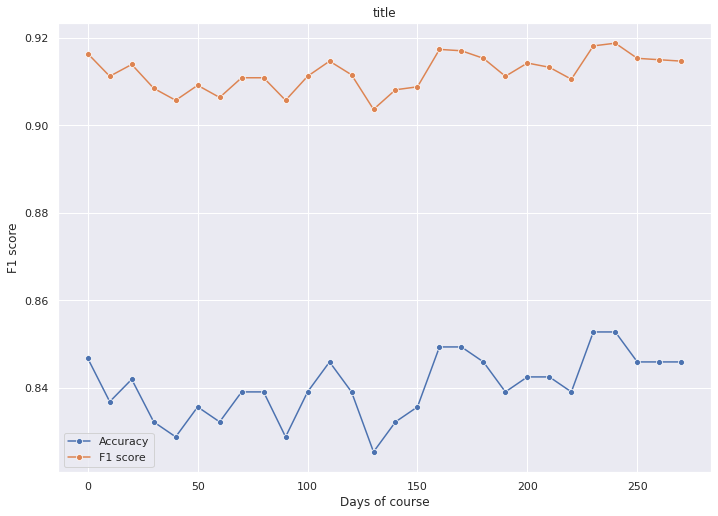

In [ ]:
plot_days(deadline_list,result, "title")

In [ ]:
result[15][4]

array([[  5,  41],
       [  7, 239]])

##### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset(df_day, ["2013J"],"2014J")
  
  nb = GaussianNB()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

In [ ]:
plot_days(deadline_list,result, "title")

##### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset(df_day, ["2013J"],"2014J")
  
  nb = KNeighborsClassifier()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

In [ ]:
plot_days(deadline_list,result, "title")

# OTHER STUFF

In [ ]:
df_cp

NameError: ignored

In [ ]:
df_cp = df[0].loc[df[0]['code_presentation']=="2013J"]
df_cp = df_cp[["id_student"]]
df_cp['final_result'] = df[0].loc[df[0]['code_presentation']=="2013J"].final_result.replace({1:0, 2:1, 3:1})
df_cp['mean_click_0'] =  df[0].loc[df[0]['code_presentation']=="2013J"].mean_click

for i in range(len(df[1:])):
  df_cp[f'mean_click_{i}'] = df[i].loc[df[i]['code_presentation']=="2013J"].mean_click


In [ ]:
for i in range(len(df[1:])):
   

In [ ]:
df_cp.loc[df_cp['final_result']==0]

In [ ]:
df_cp = df[7].loc[df[7]['code_presentation']=="2013J"]
df_cp = df_cp[["id_student", "final_result"]]
#df_cp["mean_click_list"] = [0] * len(df_cp)

In [ ]:
# df_cp["mean_click_list_7"] = df[7].loc[df[7]['code_presentation']=="2013J"].mean_click
# df_cp["mean_click_list_14"] = df[14].loc[df[14]['code_presentation']=="2013J"].mean_click
# df_cp["mean_click_list_21"] = df[21].loc[df[21]['code_presentation']=="2013J"].mean_click
# df_cp["mean_click_list_27"] = df[27].loc[df[27]['code_presentation']=="2013J"].mean_click

In [ ]:
df_cp

In [ ]:
df_cp_14[["id_student", "mean_click"]]

In [ ]:
for i in range(1,4):
  print(7*i)
  df[7*i].head()

In [ ]:
# from sklearn.inspection import permutation_importance

# importance = permutation_importance(randomforest, X_test, Y_test)
# print(importance.importances_mean)

# feature_names = randomforest.feature_names_in_

# plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
# plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
# plt.show()

# importance_table = pd.DataFrame({'importance': importance['importances_mean'],
#                                  'column': feature_names })
# importance_table.sort_values(by = 'importance', ascending = False)[:20]